In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from rich.pretty import pprint

from omnivault.transformer.core.dataset import construct_dummy_batch_future_masks
from omnivault.transformer.modules.attention.core import MultiHeadedAttention, ScaledDotProductAttention
from omnivault.utils.reproducibility.seed import seed_all

## Test Scaled Dot-Product Attention QKV Same Size
 
1. The output shapes of the context vector and attention weights are as expected.
2. The attention weights across the sequence sum up to 1 for each head in each batch, adhering to the properties of a softmax distribution.
3. Each attention weight is within the range [0, 1], which is necessary since they are probabilities.

In [2]:
seed_all(42)

B, H, L, D = 4, 8, 32, 512  # batch size, head, context length, embedding dimension
Q = torch.rand(B, H, L, D)  # query
K = torch.rand(B, H, L, D)  # key
V = torch.rand(B, H, L, D)  # value

# Scaled Dot-Product Attention
attention = ScaledDotProductAttention(dropout=0.0)
context_vector, attention_weights = attention(Q, K, V)

assert context_vector.shape == (B, H, L, D)
assert attention_weights.shape == (B, H, L, L)
pprint(context_vector.shape)
pprint(attention_weights.shape)

# assert each row of attention_weights sums to 1
# assert each element of attention_weights is between 0 and 1
attention_weights_summed_over_sequences = attention_weights.sum(dim=-1)
assert torch.allclose(
    attention_weights_summed_over_sequences, torch.ones(B, H, L)
), "The attention weights distribution induced by softmax should sum to 1."
assert torch.all(
    (0 <= attention_weights) & (attention_weights <= 1)
), "All attention weights should be between 0 and 1."

/Users/gaohn/gaohn/omniverse/omnivault/transformer/utils/reproducibility.py:69: UserWarning: Deterministic mode is activated. This will negatively impact performance and may cause increase in CUDA memory footprint.
  configure_deterministic_mode()


torch.Size([4, 8, 32, 512])

torch.Size([4, 8, 32, 32])

## Test Scaled Dot-Product Attention QKV Different Size

In [3]:
seed_all(42)
B, H, S, T, D = 4, 8, 40, 32, 512  # batch size, head, source length, target length, embedding dimension

Q = torch.rand(B, H, T, D)  # query
K = torch.rand(B, H, S, D)  # key
V = torch.rand(B, H, S, D)  # value

attention = ScaledDotProductAttention(dropout=0.0)
context_vector, attention_weights = attention(Q, K, V)
assert context_vector.shape == (B, H, T, D)
assert attention_weights.shape == (
    B,
    H,
    T,
    S,
)  # Because each query in T attensds to all keys in S, which is why the last dimension of attention_weights is S, representing the sequence length of Key.
# assert each row of attention_weights sums to 1
# assert each element of attention_weights is between 0 and 1
attention_weights_summed_over_sequences = attention_weights.sum(dim=-1)
assert torch.allclose(
    attention_weights_summed_over_sequences, torch.ones(B, H, T)
), "The attention weights distribution induced by softmax should sum to 1."
assert torch.all(
    (0 <= attention_weights) & (attention_weights <= 1)
), "All attention weights should be between 0 and 1."


## MHA Layer Test

In [4]:
seed_all(42)

B, H, L, D = 4, 8, 32, 512  # batch size, head, context length, embedding dimension
dropout, bias = 0.0, False
attention = ScaledDotProductAttention(dropout=0.0)

mha = MultiHeadedAttention(attention=attention, H=H, d_model=D, dropout=dropout, bias=bias)

# test self attention shape without mask
z = torch.rand(B, L, D)
output = mha(query=z, key=z, value=z, mask = None)
assert output.shape == (B, L, D)
pprint(output.shape)

torch.Size([4, 32, 512])

## MHA Future Masking

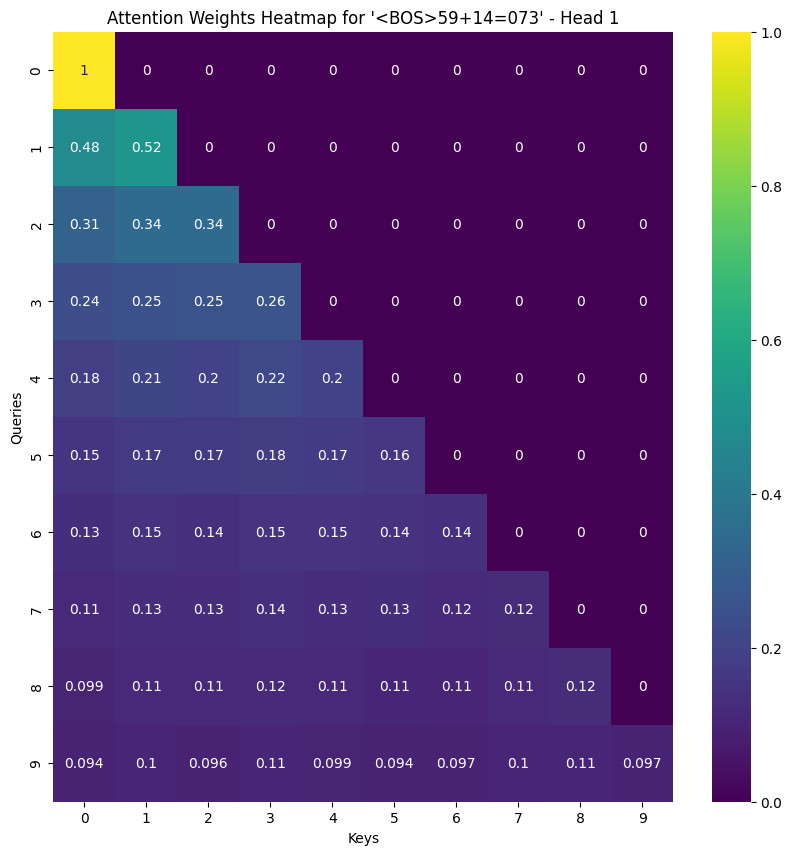

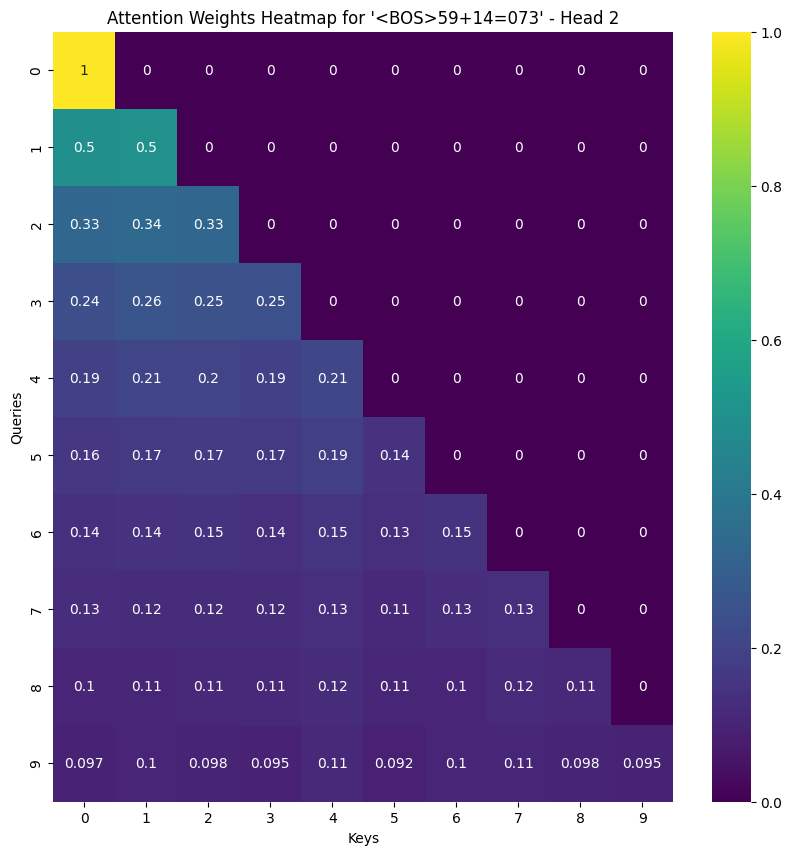

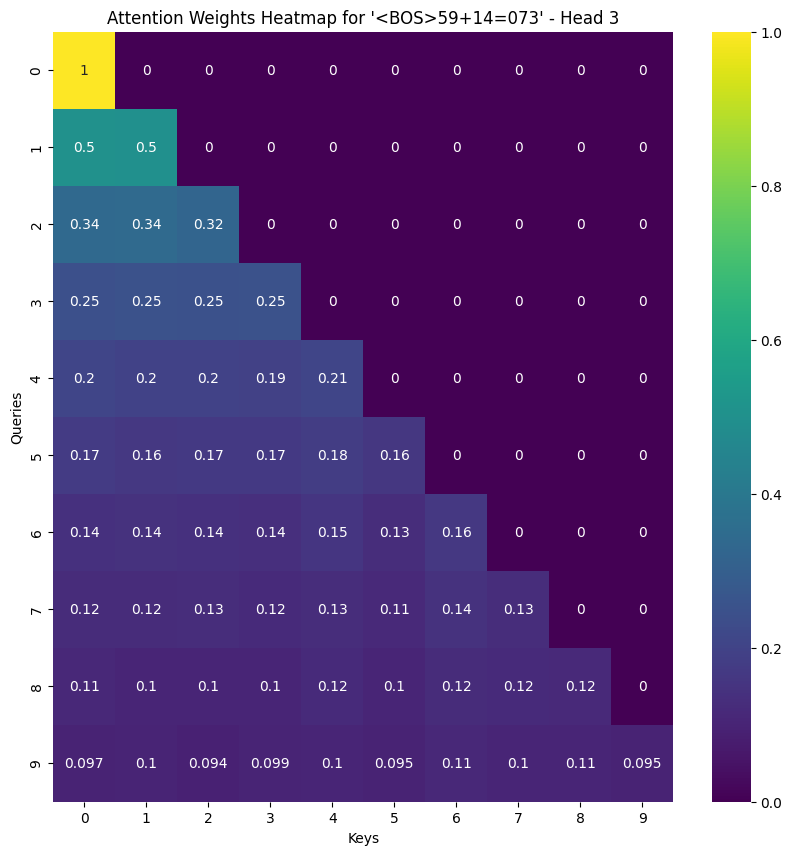

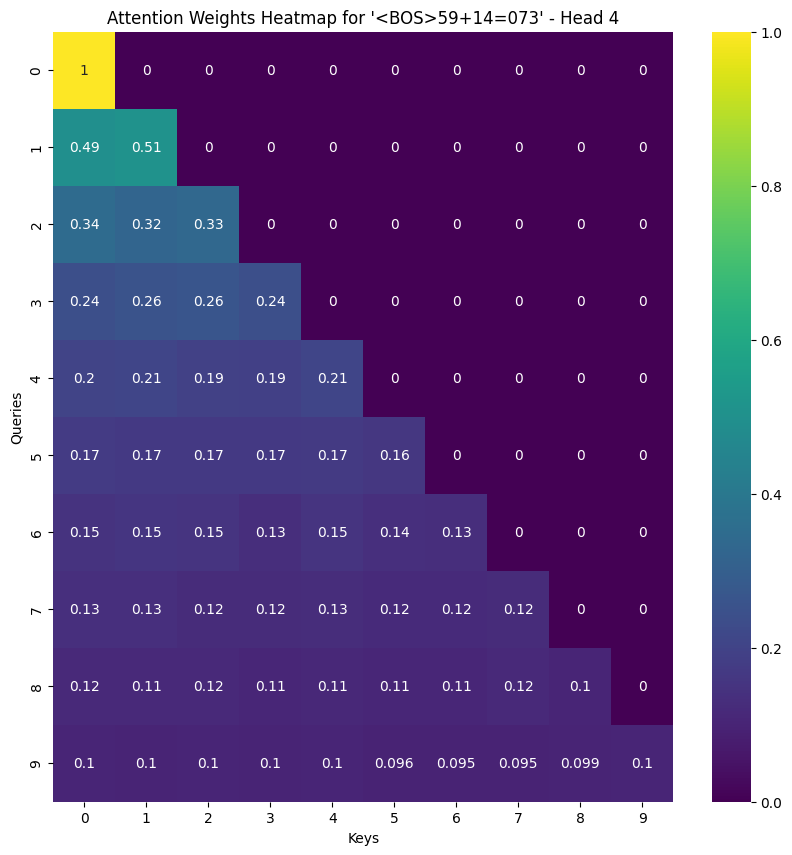

In [5]:
# test self attention shape with future mask
seed_all(42)
B, H, L, D = 4, 4, 10, 512  # batch size, head, context length, embedding dimension

casaul_mha = MultiHeadedAttention(attention=attention, H=H, d_model=D, dropout=dropout, bias=bias)
future_mask = construct_dummy_batch_future_masks(batch_size=B, seq_len=L)
z = torch.rand(B, L, D)
output = casaul_mha(query=z, key=z, value=z, mask = future_mask)
assert output.shape == (B, L, D)
attention_weights = casaul_mha.attention_weights
assert attention_weights.shape == (B, H, L, L)

for head in range(H):
    plt.figure(figsize=(10, 10))

    # Extract attention weights for the last sample in the last batch for this head
    attention_matrix = attention_weights[-1, head, :, :].detach().numpy()

    sns.heatmap(attention_matrix, annot=True, cmap='viridis')
    plt.title(f"Attention Weights Heatmap for '<BOS>59+14=073' - Head {head+1}")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()

## Variance of Scaled Dot-Product Attention

There is a factor of about 512.

When you initialize the query $Q$ and key $K$ matrices with elements from a
normal distribution with a standard deviation $\sigma$ of 1, the variance of
these elements is $\sigma^2$, which is also 1 since $\sigma = 1$.

Now, when you compute the dot product $Q \cdot K^T$ for a single pair of vectors
$q$ and $k$, you sum up $d_k$ products of pairs of normally distributed
variables. If these variables were independent, the variance of the sum would
indeed be $d_k \times \sigma^2$, because variances of independent variables add
up.

In your case, since $\sigma^2 = 1$, the variance of the sum before scaling is
expected to be $d_k \times \sigma^2 = d_k \times 1 = d_k$, which is 512 for
$d_k = 512$. This is why the unscaled variance is approximately 512 times larger
than the scaled variance.

The scaling factor $\frac{1}{\sqrt{d_k}}$ is then used to scale down the summed
variances back to $\sigma^2$, which is 1. This is done by dividing the dot
product by $\sqrt{d_k}$, which reduces the variance of the sum by a factor of
$d_k$ because when scaling a random variable by a constant, the variance is
scaled by the square of that constant.

In summary, yes, the factor of 512 in the unscaled variance is normal and
directly corresponds to the dimensionality $d_k$ of the key/query vectors in the
attention mechanism. The scaling factor is applied to control this variance and
maintain the stability of the gradients during training.

In [6]:
seed_all(92)  # 6

# Set the dimensionality of the keys and queries
d_k = 512
# Set the batch size, number of heads, and sequence length
B, H, L = 4, 8, 32
# Standard deviation for initialization
sigma = 1.0

# Initialize Q and K with variance sigma^2
Q = torch.randn(B, H, L, d_k) * sigma
K = torch.randn(B, H, L, d_k) * sigma

# Calculate dot products without scaling
unscaled_dot_products = torch.matmul(Q, K.transpose(-2, -1))

# Calculate the variance of the unscaled dot products
unscaled_variance = unscaled_dot_products.var(unbiased=False)

# Apply the scaling factor 1 / sqrt(d_k)
scaled_dot_products = unscaled_dot_products / torch.sqrt(torch.tensor(d_k).float())

# Calculate the variance of the scaled dot products
scaled_variance = scaled_dot_products.var(unbiased=False)

# Apply softmax to the scaled and unscaled dot products
softmax_unscaled = torch.nn.functional.softmax(unscaled_dot_products, dim=-1)
softmax_scaled = torch.nn.functional.softmax(scaled_dot_products, dim=-1)

# Display the calculated variances
print(f"Unscaled Variance: {unscaled_variance}")
print(f"Scaled Variance: {scaled_variance}")

Unscaled Variance: 512.0117797851562
Scaled Variance: 1.0000230073928833


/Users/gaohn/gaohn/omniverse/omnivault/transformer/utils/reproducibility.py:69: UserWarning: Deterministic mode is activated. This will negatively impact performance and may cause increase in CUDA memory footprint.
  configure_deterministic_mode()


## MHA Derived Using For Loop and Matrix Multiplication

In [ ]:
# mypy: ignore-errors
import copy
import math
from abc import ABC, abstractmethod

import rich
import torch
from attention import attention
from common_utils.core.common import seed_all
from d2l import torch as d2l
from rich.pretty import pprint
from torch import nn
from torch.nn import Transformer

seed_all(42, seed_torch=True)


class MultiHeadedAttention(nn.Module):
    def __init__(self, H, d_model, dropout=0.1, bias=False) -> None:
        "Take in model size and number of heads."
        super().__init__()
        assert d_model % H == 0

        self.d_model = d_model  # D
        self.d_k = d_model // H  # stay true to notations
        self.d_q = d_model // H
        self.d_v = d_model // H

        self.H = H  # number of heads

        # shadow my notations
        self.W_q = nn.Linear(self.d_model, self.d_q * self.H, bias=bias)  # D x D
        self.W_k = nn.Linear(self.d_model, self.d_k * self.H, bias=bias)
        self.W_v = nn.Linear(self.d_model, self.d_v * self.H, bias=bias)
        self.W_o = nn.Linear(self.d_model, self.d_model, bias=bias)

        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, embeddings, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches, seq_len, _ = embeddings.size()

        # Apply linear transformations to compute Q, K, V
        # NOTE: here is an important misconception that if you have
        # 8 heads, then you SPLIT the embeddings into 8 parts and
        # then apply linear transformations to each part. This is
        # WRONG. You apply linear transformations to the whole
        # embeddings and then split the result into 8 parts.
        W_q = self.W_q.weight  # D x D
        W_k = self.W_k.weight  # D x D
        W_v = self.W_v.weight  # D x D

        # NOTE: in pytorch, you need to transpose the weight matrix if
        # you see their formula, so this has a bit of a different
        # notation than in our notes. In our notes, we do not need to transpose.

        Q = embeddings @ W_q.T  # Z @ W_q
        K = embeddings @ W_k.T  # Z @ W_k
        V = embeddings @ W_v.T  # Z @ W_v
        assert tensors_are_same(Q, self.W_q(embeddings))
        assert tensors_are_same(K, self.W_k(embeddings))
        assert tensors_are_same(V, self.W_v(embeddings))

        # Q = self.W_q(embeddings) # Z @ W_q
        # K = self.W_k(embeddings) # Z @ W_k
        # V = self.W_v(embeddings) # Z @ W_v
        assert Q.shape == (nbatches, seq_len, self.d_q * self.H)

        # Splitting into multiple heads
        Q_heads = []
        K_heads = []
        V_heads = []

        for head in range(self.H):
            # ASSUMING d_q == d_k == d_v
            # NOTE: see my notes on confusion of paper's usage of
            # W^{q}_i, W^{k}_i, W^{v}_i where in fact the
            # weights are shared across heads via W^{q}, W^{k}, W^{v}
            head_start = head * self.d_q
            head_end = (head + 1) * self.d_q

            # NOTE: W_q_h, W_k_h, W_v_h are computed just to check that
            # Q_h = embeddings @ W_q_h^T
            W_q_h = W_q.T[:, head_start:head_end]  # D x d_q
            W_k_h = W_k.T[:, head_start:head_end]  # D x d_k
            W_v_h = W_v.T[:, head_start:head_end]  # D x d_v

            Q_h = Q[:, :, head_start:head_end]
            pprint(embeddings.shape)
            pprint(W_q_h.T.shape)
            assert tensors_are_same(Q_h, embeddings @ W_q_h)  # Z @ W^{q}_h

            K_h = K[:, :, head_start:head_end]
            assert tensors_are_same(K_h, embeddings @ W_k_h)

            V_h = V[:, :, head_start:head_end]
            assert tensors_are_same(V_h, embeddings @ W_v_h)

            assert Q_h.shape == (nbatches, seq_len, self.d_q)
            assert K_h.shape == (nbatches, seq_len, self.d_k)
            assert V_h.shape == (nbatches, seq_len, self.d_v)

            Q_heads.append(Q_h)
            K_heads.append(K_h)
            V_heads.append(V_h)

        # as of now we are at the stage
        # right before head_h = attention(Q_h, K_h, V_h)
        # so next step apply attention to each head h.

        # Apply attention to each head
        head_outputs = []
        for Q_h, K_h, V_h in zip(Q_heads, K_heads, V_heads):
            # apply Q,K,V to attention
            # x.shape = [nbatches, seq_len, d_v] = [2, 4, 100] or [2, 4, 50] if 2 heads
            x, attn = attention(Q_h, K_h, V_h, mask=mask, dropout=self.dropout)
            head_outputs.append(x)
            # FIXME: why is attn unused?
            self.attn = attn  # Store attention

        # Concatenate heads
        # NOTE: this is the step where we concatenate the heads
        # MultiHead(Q, K, V) = Concat(head_1, ..., head_H)W^{o}
        x_concat = torch.cat(head_outputs, dim=-1)
        pprint(x_concat.shape)
        assert x_concat.shape == (nbatches, seq_len, self.d_model)

        # Apply final linear transformation
        return self.W_o(x_concat)


def tensors_are_same(tensor1, tensor2, atol=1e-8, rtol=1e-5):
    return torch.allclose(tensor1, tensor2, atol=atol, rtol=rtol)


if __name__ == "__main__":
    num_hiddens, num_heads = 100, 2
    model = MultiHeadedAttention(H=num_heads, d_model=num_hiddens, bias=False)
    batch_size, num_queries, num_kvpairs = 2, 4, 6
    valid_lens = torch.tensor([3, 2])
    X = torch.ones((batch_size, num_queries, num_hiddens))  # shape = [2, 4, 100]
    # Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
    # check the output shape
    # out_mask = model(X, Y, Y, mask=torch.ones((batch_size, num_queries, num_kvpairs)))
    out_no_mask = model.forward(embeddings=X, mask=None)
    # torch.save(out_no_mask, "ground_truth_attention.pt")
    # pprint(out_no_mask)
    # print(out_no_mask.shape)

    if num_heads == 1:
        loaded_out = torch.load("single_head_ground_truth_attention.pt")
    elif num_heads == 2:
        loaded_out = torch.load("double_head_ground_truth_attention.pt")
    else:
        raise ValueError("num_heads must be 1 or 2")

    if tensors_are_same(out_no_mask, loaded_out, atol=0, rtol=0):
        print("The tensors are the same!")
    else:
        print("The tensors are different!")
